# Big Data avec les Jeux Olympiques

## Lecture des données

### Fichier athlete_events.csv

In [1]:
import csv

with open("athlete_events.csv") as fichier:
    lecteur_csv = csv.DictReader(fichier)
    data = [enregistrement for enregistrement in lecteur_csv]

print("Le fichier 'athlete_events.csv' contient {} enregistrements".format(len(data)))
print("Exemple (premier enregistrement):")
print(data[0])

Le fichier 'athlete_events.csv' contient 271116 enregistrements
Exemple (premier enregistrement):
{'ID': '1', 'Name': 'A Dijiang', 'Sex': 'M', 'Age': '24', 'Height': '180', 'Weight': '80', 'Team': 'China', 'NOC': 'CHN', 'Games': '1992 Summer', 'Year': '1992', 'Season': 'Summer', 'City': 'Barcelona', 'Sport': 'Basketball', 'Event': "Basketball Men's Basketball", 'Medal': 'NA'}


### Inclusion des code de pays (NOC)

Les valeurs dont la clé est `"NOC"` sont des codes pays sur 3 chiffres. S'il est évident que `CHN` fait référence à la chine, c'est moins évident pour d'autres. 

Le fichier `noc_regions.csv` est justement là pour nous donner ces informations essentielles:

In [2]:
# On n'utilise pas ici csv.DictReader mais un simple csv.reader: la
# différence est que l'on obtient des tableaux (qui devraient idéalement
# être des tuples) contenant les données, plutôt qu'un dictionnaire.
# C'est largement suffisant ici, vu que seules les deux premières composantes
# nous intéressent.

with open("noc_regions.csv") as fichier:
    lecteur_csv = csv.reader(fichier)
    liste_nocs = [enregistrement for enregistrement in lecteur_csv]
    
    # On oublie l'en-tête:
    liste_nocs = liste_nocs[1:]

print("Le fichier 'noc_regions.csv' contient {} enregistrements".format(len(liste_nocs)))
print("Exemple (premier enregistrement):")
print(liste_nocs[0])

Le fichier 'noc_regions.csv' contient 230 enregistrements
Exemple (premier enregistrement):
['AFG', 'Afghanistan', '']


### Fusion des deux tables

On commence par créer un dictionnaire associant à chaque code NOC le nom de la région correspondante.

In [3]:
dico_NOC = {}
for code, région, _ in liste_nocs:
    dico_NOC[code] = région

In [4]:
# Le code NOC de Singapour est maintenant SGP, il faut le rajouter
# manuellement sous peine de déclencher une erreur par la suite
dico_NOC['SGP'] = dico_NOC['SIN']

Puis on rajoute la bonne information pour chaque événement de la première table:

In [5]:
for t in data:
    code = t['NOC']
    t['Region'] = dico_NOC[code]

### Création d'une BDR avec pysqlite3

Maintenant que l'on a étudié les SGBDR, pourquoi ne pas se servir de la puissance des requêtes SQL pour résoudre les exercices ?

Cette possibilité reste bien entendu optionnelle, mais ça peut être une alternative intéressante.

On relit à nouveau les fichiers CSV, mais pas sous forme de dictionnaire cette fois.

In [6]:
import csv

with open("athlete_events.csv") as fichier:
    lecteur_csv = csv.reader(fichier)
    csv_events = [enregistrement for enregistrement in lecteur_csv]
# On "oublie" l'en-tête:
csv_events = csv_events[1:]

with open("noc_regions.csv") as fichier:
    lecteur_csv = csv.reader(fichier)
    csv_nocs = [enregistrement for enregistrement in lecteur_csv]
    
# On oublie l'en-tête:
csv_nocs = csv_nocs[1:]

# On reprend chaque enregistrement, pour ne garder que les 2 premières composantes:
for i in range(len(csv_nocs)):
    csv_nocs[i] = csv_nocs[i][:2]
    
csv_nocs.append(("SGP", "Singapor"))

In [7]:
import sqlite3 as sql

with sql.connect("JO.db") as conn:
    cur = conn.cursor()
    
    # On rajoute cette directive ("pragma") pour que les contraintes
    # de référence soient vérifiées par sqlite3, ce qui n'est pas
    # le comportement par défaut.
    cur.execute("PRAGMA  foreign_keys = ON")
    conn.commit()
    
    # Nettoyage et effacement de la base de données existante
    cur.execute("DROP TABLE IF EXISTS Event")
    cur.execute("DROP TABLE IF EXISTS NOC")
    conn.commit()

    # Création des tables
    cur.execute("""
    CREATE TABLE NOC (
        NOC VARCHAR(3) PRIMARY KEY,
        Region Text
    )
    """)

    cur.execute("""
    CREATE TABLE Event (
        ID TEXT, -- Attention, l'ID est attaché à un athlète, il n'est donc pas unique !
        Name TEXT,
        Sex TEXT CHECK(Sex = "M" OR Sex = "F"),
        Age INT,
        Height INT,
        Weight INT,
        Team TEXT,
        NOC VARCHAR(3) REFERENCES NOC(NOC),
        Games TEXT,
        Year INT,
        Season TEXT CHECK(Season = "Summer" OR Season = "Winter"),
        City TEXT,
        Sport TEXT,
        Event TEXT,
        Medal TEXT CHECK(Medal IN ("Gold", "Silver", "Bronze", "NA"))
    )
    """)
    conn.commit()
    
    cur.executemany("INSERT INTO NOC VALUES (?, ?)", csv_nocs)
    conn.commit()
    
    cur.executemany("INSERT INTO Event VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", csv_events)
    conn.commit()

---
## Exercice 2

Visualisez l'évolution du nombre de médailles obtenues par les femmes au cours des années.

### Version "classique" avec données python

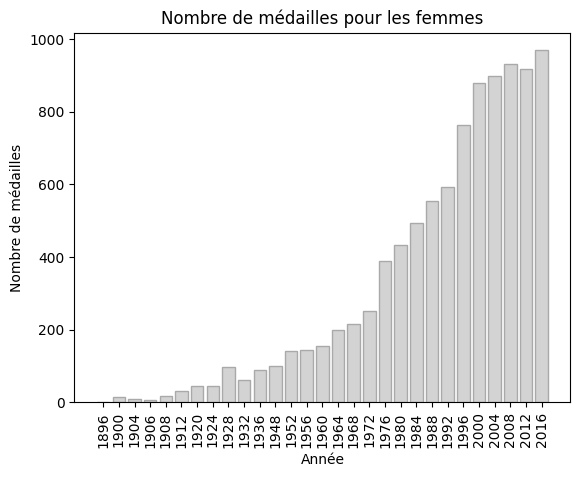

In [8]:
dico_year = {}

# On commence par compter le nombre de médailles pour les femmes, pour chaque année
for evt in data:
    if evt["Season"] == "Summer":
        year = int(evt["Year"])
        if year not in dico_year:
            dico_year[year] = 0

        if evt["Sex"] == "F" and evt["Medal"] != "NA":
            dico_year[year] += 1
        
# On crée ensuite une liste TRIÉE des années, qui servira d'abscisses pour le graphe
years = []
for y in dico_year:
    years.append(y)
    
years.sort()

# On crée ensuite le tableau correspondant des effectifs, qui servira d'ordonnées pour le graphe
# Il est capital d'utiliser le tableau déjà trié précédent.
numbers = [dico_year[y] for y in years]

from matplotlib import pyplot as plt

plt.bar(range(len(numbers)), numbers, color="lightgrey", edgecolor="darkgrey")
plt.xticks(range(len(numbers)), years, rotation=90)
plt.title("Nombre de médailles pour les femmes")
plt.xlabel("Année")
plt.ylabel("Nombre de médailles")

# On peut ajuster la taille de l'image
# (Exécuter deux fois pour que jupyter lab en tienne compte)
# Attention, il s'agit de pouces (inches). 1cm = 2.54in
plt.rcParams["figure.figsize"] = (30/2.54, 10/2.54)

plt.show()

### Version sqlite3

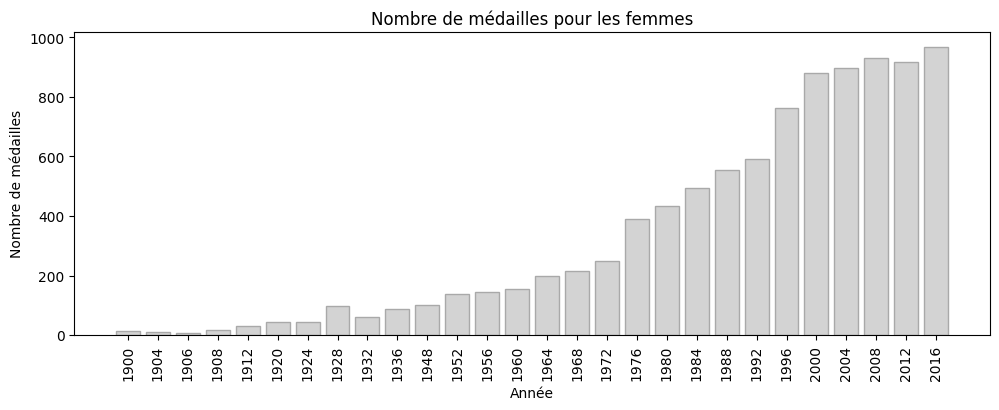

In [9]:
with sql.connect("JO.db") as conn:
    cur = conn.cursor()
    
    cur.execute("""
    SELECT Year, COUNT(Medal) 
    FROM Event
    WHERE Medal <> "NA" AND Season = "Summer" AND Sex = "F"
    GROUP BY Year
    ORDER BY Year
    """)
    
    # On utilise fetchall() pour récupérer toutes les lignes de la requête dans un tableau python,
    # qu'il ne reste qu'à séparer en deux pour être utilisé par matplotlib
    years = []
    numbers = []
    for year, count in cur.fetchall():
        years.append(year)
        numbers.append(count)
        
from matplotlib import pyplot as plt

plt.bar(range(len(numbers)), numbers, color="lightgrey", edgecolor="darkgrey")
plt.xticks(range(len(numbers)), years, rotation=90)
plt.title("Nombre de médailles pour les femmes")
plt.xlabel("Année")
plt.ylabel("Nombre de médailles")

# On peut ajuster la taille de l'image
# (Exécuter deux fois pour que jupyter lab en tienne compte)
# Attention, il s'agit de pouces (inches). 1cm = 2.54in
plt.rcParams["figure.figsize"] = (30/2.54, 10/2.54)

plt.show()

### Bonus: la même chose mais en séparant les 3 types de médailles

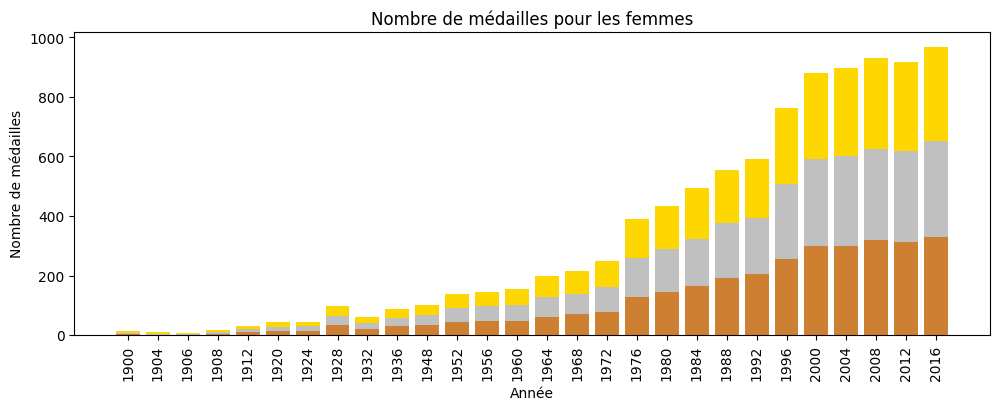

In [10]:
with sql.connect("JO.db") as conn:
    cur = conn.cursor()
    
    cur.execute("""
    SELECT Year, Medal, COUNT(Medal) 
    FROM Event
    WHERE Medal <> "NA" AND Season = "Summer" AND Sex = "F"
    GROUP BY Year, Medal
    ORDER BY Year
    """)
    
    # On utilise fetchall() pour récupérer toutes les lignes de la requête dans un tableau python,
    # qu'il ne reste qu'à séparer en deux pour être utilisé par matplotlib
    years = []
    ngold = []
    nsilver = []
    nbronze = []
    
    for year, medal, count in cur.fetchall():
        # Attention, il ne faut pas ajouter plusieurs fois une année
        if year not in years:
            years.append(year)
            
        if medal == "Gold":
            ngold.append(count)
        elif medal == "Silver":
            nsilver.append(count)
        else:
            assert medal == "Bronze"
            nbronze.append(count)

# On doit ajouter les effectifs des bronzes aux argents, pour que les barres se superposent
# correctement. De même, il faut ajouter les effectifs des bronze ET des argents aux ors.
for i in range(len(years)):
    nsilver[i] += nbronze[i]
    ngold[i] += nsilver[i]
            
from matplotlib import pyplot as plt

plt.bar(range(len(years)), ngold, color="gold")
plt.bar(range(len(years)), nsilver, color="silver")
plt.bar(range(len(years)), nbronze, color="#CD7F32")
plt.xticks(range(len(years)), years, rotation=90)
plt.title("Nombre de médailles pour les femmes")
plt.xlabel("Année")
plt.ylabel("Nombre de médailles")

# On peut ajuster la taille de l'image
# (Exécuter deux fois pour que jupyter lab en tienne compte)
# Attention, il s'agit de pouces (inches). 1cm = 2.54in
plt.rcParams["figure.figsize"] = (30/2.54, 10/2.54)

plt.show()

---
## Exercice 3
Affichez le diagramme des 5 pays ayant remporté le plus grand nombre de médailles, toutes époques confondues.

### Version "classique" avec données python

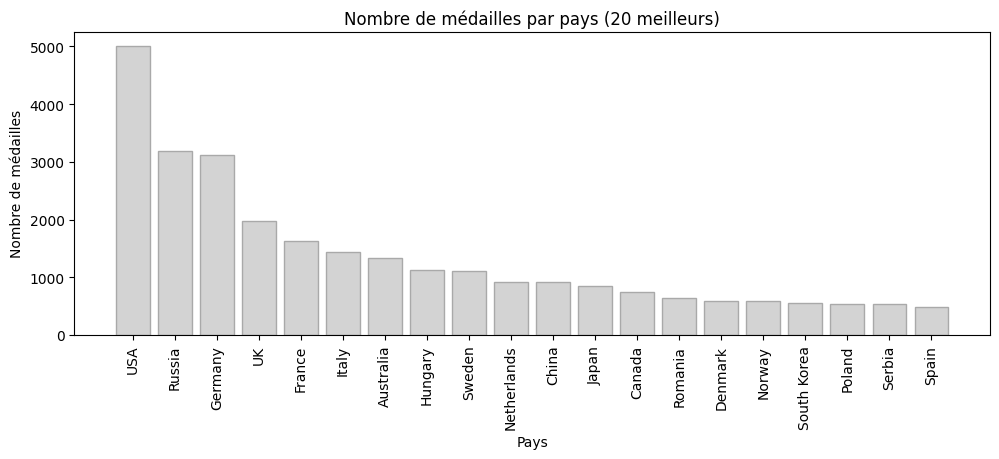

In [11]:
# On commence par extraire les données qui nous intéressent à l'aide d'un dictionnaire
dico_pays = {}
for evt in data:
    if evt["Season"] == "Summer":
        if evt["Region"] not in dico_pays:
            dico_pays[evt["Region"]] = 0
            
        if evt["Medal"] != "NA":
            dico_pays[evt["Region"]] += 1
            
# On transforme ce dictionnaire en un tableau de tuples (Pays, Médailles)
table = [(pays, nbr) for pays, nbr in dico_pays.items()]

# On trie cette table suivant la deuxième composante, dans l'ordre décroissant
def seconde_composante(tpl):
    return tpl[1]
table.sort(key=seconde_composante, reverse=True)

# On ne garde que les 20 meilleurs
table = table[:20]

# On découpe en deux tableaux (abscisses, ordonnées)
pays = []
numbers = []

for p, n in table:
    pays.append(p)
    numbers.append(n)
    
from matplotlib import pyplot as plt

plt.bar(range(len(numbers)), numbers, color="lightgrey", edgecolor="darkgrey")
plt.xticks(range(len(numbers)), pays, rotation=90)
plt.title("Nombre de médailles par pays (20 meilleurs)")
plt.xlabel("Pays")
plt.ylabel("Nombre de médailles")

# On peut ajuster la taille de l'image
# (Exécuter deux fois pour que jupyter lab en tienne compte)
# Attention, il s'agit de pouces (inches). 1cm = 2.54in
plt.rcParams["figure.figsize"] = (30/2.54, 10/2.54)

plt.show()

### Version SQL

On veut créer le même diagramme, mais en séparant par couleurs de médailles.
Il est délicat de réaliser cela en une unique requête sql: la méthode utilisée précédemment ne fonctionnerait pas car elle ne permettrait pas de faire le tri si on découpe à l'avance par type de médailles.

Les requêtes sur la BDD étant extrêmement rapides, on ne se fatigue pas et on procède en plusieurs fois:
* Première requête pour récupérer les 20 meilleurs pays, toutes médailles confondues
* Les 3 requêtes suivantes, pour récupérer les médailles par types

Bien sûr, il faut utiliser une JOINture puisque les noms de régions sont dans une seconde table.

On utilise la clause `LIMIT 20` pour ne garder que les 20 premières entrées.

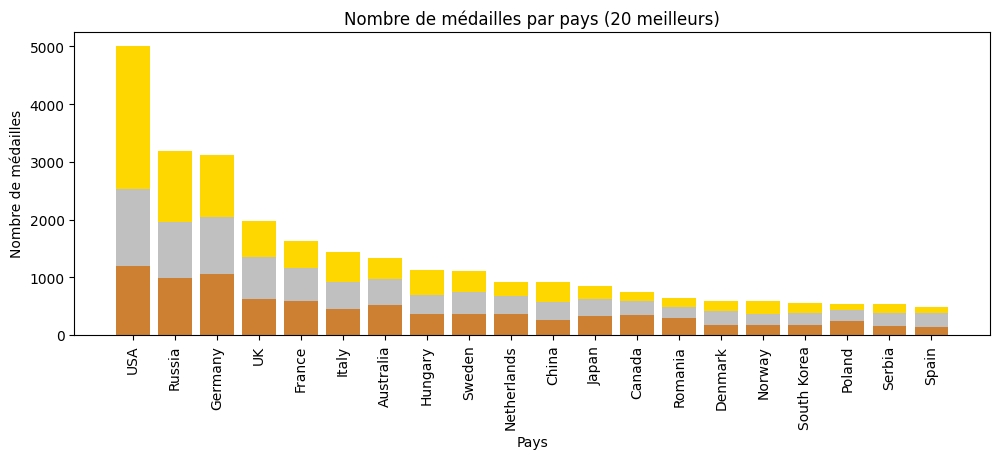

In [12]:
N = 20

with sql.connect("JO.db") as conn:
    cur = conn.cursor()
    
    cur.execute("""
    SELECT Region FROM NOC
    JOIN Event ON NOC.NOC = Event.NOC
    WHERE Medal <> "NA" AND Season = "Summer"
    GROUP BY Region
    ORDER BY COUNT(Medal) DESC
    LIMIT {}
    """.format(N))
    
    # On récupère un tableau de tuples à 1 composante: on le
    # transforme en un simple tableau
    pays = [p[0] for p in cur.fetchall()]
    
    # On crée une liste des pays sous forme de chaîne de caractère, 
    # qui pourra servir pour les requêtes suivantes
    pays_str = ", ".join([repr(p) for p in pays])

    nbronze = [0] * len(pays)
    nsilver = [0] * len(pays)
    ngold = [0] * len(pays)
    
    # Requête 2: médailles de bronze
    cur.execute("""
    SELECT Region, COUNT(Medal) FROM NOC
    JOIN EVENT ON NOC.NOC = Event.NOC
    WHERE Medal = "Bronze" AND Season = "Summer" AND Region IN ({})
    GROUP BY REGION
    """.format(pays_str))
    
    for p, n in cur.fetchall():
        i = pays.index(p)
        nbronze[i] = n

    # Requête 3: médailles d'argent
    cur.execute("""
    SELECT Region, COUNT(Medal) FROM NOC
    JOIN EVENT ON NOC.NOC = Event.NOC
    WHERE Medal = "Silver" AND Season = "Summer" AND Region IN ({})
    GROUP BY REGION
    """.format(pays_str))
    
    for p, n in cur.fetchall():
        i = pays.index(p)
        # On prévoit tout de suite le décallage pour superposer les barres avec matplotlib
        nsilver[i] = n + nbronze[i]

    # Requête 4: médailles d'argent
    cur.execute("""
    SELECT Region, COUNT(Medal) FROM NOC
    JOIN EVENT ON NOC.NOC = Event.NOC
    WHERE Medal = "Gold" AND Season = "Summer" AND Region IN ({})
    GROUP BY REGION
    """.format(pays_str))
    
    for p, n in cur.fetchall():
        i = pays.index(p)
        # On prévoit tout de suite le décallage pour superposer les barres avec matplotlib
        ngold[i] = n + nsilver[i]

    from matplotlib import pyplot as plt

    plt.bar(range(len(pays)), ngold, color="gold")
    plt.bar(range(len(pays)), nsilver, color="silver")
    plt.bar(range(len(pays)), nbronze, color="#CD7F32")
    plt.xticks(range(len(pays)), pays, rotation=90)
    plt.title("Nombre de médailles par pays ({} meilleurs)".format(N))
    plt.xlabel("Pays")
    plt.ylabel("Nombre de médailles")

    # On peut ajuster la taille de l'image
    # (Exécuter deux fois pour que jupyter lab en tienne compte)
    # Attention, il s'agit de pouces (inches). 1cm = 2.54in
    plt.rcParams["figure.figsize"] = (30/2.54, 10/2.54)

    plt.show()
